# Prov-gigapth Tutorial

**Please down load github repsitory** https://github.com/prov-gigapath/prov-gigapath  

Please fowllow the github **Install guide**

```
git clone https://github.com/prov-gigapath/prov-gigapath
cd prov-gigapath
conda env create -f environment.yaml
conda activate gigapath
pip install -e .
```

## Introduction   


### Prepocessing WSI  

#### tile imges format  
- input:  

px: 256x256 
position: 123x_123y.png   

RGB

- output:  

Array  1 x 1536 dims  [1,2.....1536]
position  1 x 2 dims  [x, y]

- save as:  

`.pt` for image embedding 
`.csv` for labeling, slide_id, image_position


#### slide imges format
- input:  

tile embedding 
tile position embedding

- output:  

images embedding 1 x 768 dims


- save as:  

`.h5` for whole slide image embedding
`.csv` for labeling, slide_id,



### File Location  

#### 1. tile encoder  

`prov-gigapath/gigapth`  
`prov-gigapath/gigapth/pipepline.py`  

#### 1.1 tile encoder_finetune  

`prov-gigapath/linear_probe/main.py` > tile level fine-tuning for 2 labels | Dataset `pcam/pcam.csv` 


#### 2. slide encoder

`slide_encoder.py &  pos_embed.py` > how to embed (x,y) position for tiles and embed at slide level.  

#### 2.1 slide encoder_finetune
`prov-gigapath/finetune & prov-gigapath/gigapth/classification_head.py` > slide level fine-tuning for 5 labels | Dataset `PANDA`  


**Important**

Please set up Nvidia driver  

`nvidia-smi` to chekc if you have or not.





## Demo  
*There is demo located in `/demo/` as well*  


### 1. download models 

#### 1.1 download tile encoder 


In [1]:
import timm
tile_encoder = timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True)

##### 1.2 check tile encoder

In [ ]:
from torchsummary import summary
summary(tile_encoder)

#### 2.1 donlowad slide encoder

In [1]:
## this is downloading from huggingface,  please obtain your personal token. https://huggingface.co/docs/hub/en/security-tokens
import os
os.environ["HF_TOKEN"] = ""

In [ ]:
# put gigapth folder with .ipynb at same directory.  
import gigapath.slide_encoder as encoder 

In [ ]:
## download slide encoding model 
## THere are 3 models (please check slide_encoder.py Line 254 to 269
# 1. enc12l768d --> embed_dim = 768, depth = 12, mlp_ratio = 4. 
slide_encoder = encoder.create_model("hf_hub:prov-gigapath/prov-gigapath", "gigapath_slide_enc12l768d", 1536)

##### 2.2 check slide encoder

In [ ]:
summary(slide_encoder)

### 2. Embedding WSI

#### 2.0 Preprocessing Data |  reference (https://www.youtube.com/watch?v=QntLBvUZR5c)

In [1]:
from openslide import open_slide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
img = "./test_ground/000026.ndpi"

In [3]:
slide = open_slide(img)

In [4]:
## show image as thumb 
slide_thumb = slide.get_thumbnail(size=(600,600)) ## resize to 600x600 px
print(type(slide_thumb))
print(slide_thumb.size)   ## width x height
slide_thumb.show()

<class 'PIL.Image.Image'>
(600, 461)


In [5]:
## convert to numpy to show 
slide_num = np.array(slide_thumb)
print(slide_num.shape) ## height x width x channels 

(461, 600, 3)


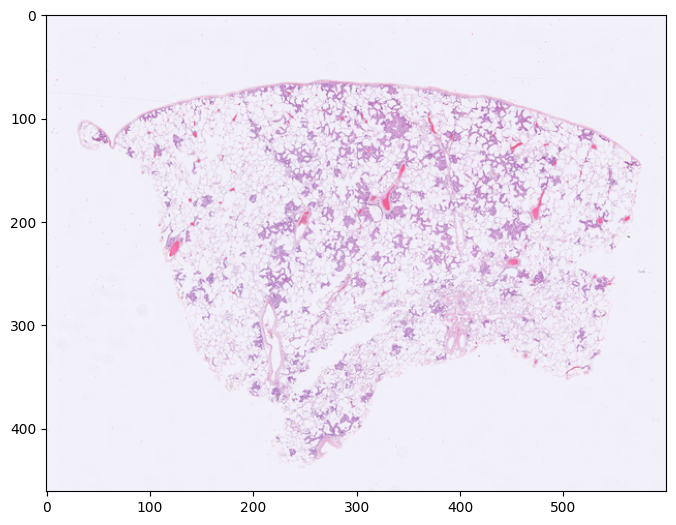

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(slide_num)

In [7]:
## different level 

factor = slide.level_downsamples 
level_dim = slide.level_dimensions
level = 0

print(f"Level    Image Size    Scaling Factor")
for i in level_dim:
    print(f"{level}\t{i}\t{factor[level]}")
    level+=1

Level    Image Size    Scaling Factor
0	(96000, 73728)	1.0
1	(48000, 36864)	2.0
2	(24000, 18432)	4.0
3	(12000, 9216)	8.0
4	(6000, 4608)	16.0
5	(3000, 2304)	32.0
6	(1500, 1152)	64.0
7	(750, 576)	128.0
8	(375, 288)	256.0


In [8]:
## different level;
level3_dim = level_dim[2]
print(level3_dim)

## load level 3 image
level3_img =slide.read_region((0,0), 2, level_dim[2])
level3_rgb = level3_img.convert('RGB')


(24000, 18432)


In [9]:
level3_np = np.array(level3_rgb)
print(level3_np.shape)

(18432, 24000, 3)


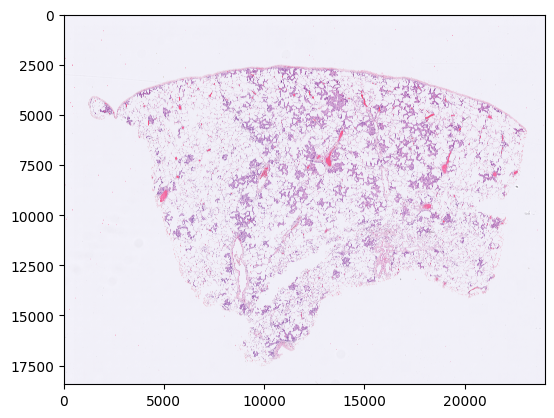

In [10]:
plt.imshow(level3_np)

In [11]:
### tile processing 
from openslide.deepzoom import DeepZoomGenerator

In [12]:
## segement as 256 x 256 px
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)

In [13]:
## check number of level
layer = 0
for i in tiles.level_dimensions:
    print(f"{layer} layer: {i} ")
    layer+=1


print(f"Total tiles for this WSI: {tiles.tile_count }")

0 layer: (1, 1) 
1 layer: (2, 2) 
2 layer: (3, 3) 
3 layer: (6, 5) 
4 layer: (12, 9) 
5 layer: (24, 18) 
6 layer: (47, 36) 
7 layer: (94, 72) 
8 layer: (188, 144) 
9 layer: (375, 288) 
10 layer: (750, 576) 
11 layer: (1500, 1152) 
12 layer: (3000, 2304) 
13 layer: (6000, 4608) 
14 layer: (12000, 9216) 
15 layer: (24000, 18432) 
16 layer: (48000, 36864) 
17 layer: (96000, 73728) 
Total tiles for this WSI: 144124


In [14]:
## different tiles and different level 
level_num = 16

print(f"tile shape at level {level_num} is: {tiles.level_tiles[level_num]}")
print(f"tiles : {tiles.level_tiles[level_num][0] * tiles.level_tiles[level_num][1]}")

tile shape at level 16 is: (188, 144)
tiles : 27072


In [ ]:
### save a whole slide image into tiles 

In [ ]:
cols, rows = tiles.level_tiles[16] ## 27k tiles 
tile_dir = "./test_groundtiles_practice/"

In [ ]:
## loop through

for row in range(rows):
    for col in range(cols):
        tile_name = os.path.join(tile_dir, '%d_%d' %(row,col))

        temp_tile = tiles.get_tile(16,(col,row))
        temp_rgb = temp_tile.convert('RGB') ## rgba > rgb
        temp_np = np.array(temp_rgb)
        plt.imsave(tile_name+".png", temp_np)

    print(f"finish saving {row}")

In [1]:
## reference to demo/run_gigapath.ipynb
# please download this pre-processing data [https://hanoverprod.z21.web.core.windows.net/gigapath/PANDA_sample_tiles.zip]


#### 2.1 Prepare Data (using example data from github)

In [4]:
## prepare data 
slide_dir = "PANDA_sample_tiles/054b6888604d963455bfff551518ece5/"
images =[os.path.join(slide_dir, img) for img in os.listdir(slide_dir) if img.endswith('.png')]
print(f"Found {len(images)} tiles")

Found 810 tiles


#### 2.2 Tile embedding

In [14]:
## Encoding Part 

## tile encoding with image and store coord from preprocessing
from gigapath.pipeline import run_inference_with_tile_encoder

tile_encoder_outputs = run_inference_with_tile_encoder(images, tile_encoder) ## batch size = 128 


Running inference with tile encoder: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.19s/it]


In [19]:
## return dic structure 
print(tile_encoder_outputs.keys())

dict_keys(['tile_embeds', 'coords'])


In [17]:
for k in tile_encoder_outputs.keys():
    print(f"tile_encoder_outputs[{k}].shape: {tile_encoder_outputs[k].shape}")

tile_encoder_outputs[tile_embeds].shape: torch.Size([810, 1536])
tile_encoder_outputs[coords].shape: torch.Size([810, 2])


In [24]:
print(tile_encoder_outputs['tile_embeds'][0]) # image
print(tile_encoder_outputs['coords'][0]) # position

tensor([-0.8817, -0.9265, -0.7653,  ..., -0.3008, -0.4806, -0.5998])
tensor([ 6040., 26952.])


#### 2.3 slide embedding

In [ ]:
## slide encoding with position 

In [28]:
from gigapath.pipeline import run_inference_with_slide_encoder

In [29]:
slide_embeds = run_inference_with_slide_encoder(slide_encoder_model=slide_encoder, **tile_encoder_outputs)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.69it/s]


In [30]:
print(slide_embeds.keys())

dict_keys(['layer_0_embed', 'layer_1_embed', 'layer_2_embed', 'layer_3_embed', 'layer_4_embed', 'layer_5_embed', 'layer_6_embed', 'layer_7_embed', 'layer_8_embed', 'layer_9_embed', 'layer_10_embed', 'layer_11_embed', 'layer_12_embed', 'last_layer_embed'])


In [32]:
for i in slide_embeds.keys():
    print(f"{i} .Shape=> {slide_embeds[i].shape}")

layer_0_embed .Shape=> torch.Size([1, 768])
layer_1_embed .Shape=> torch.Size([1, 768])
layer_2_embed .Shape=> torch.Size([1, 768])
layer_3_embed .Shape=> torch.Size([1, 768])
layer_4_embed .Shape=> torch.Size([1, 768])
layer_5_embed .Shape=> torch.Size([1, 768])
layer_6_embed .Shape=> torch.Size([1, 768])
layer_7_embed .Shape=> torch.Size([1, 768])
layer_8_embed .Shape=> torch.Size([1, 768])
layer_9_embed .Shape=> torch.Size([1, 768])
layer_10_embed .Shape=> torch.Size([1, 768])
layer_11_embed .Shape=> torch.Size([1, 768])
layer_12_embed .Shape=> torch.Size([1, 768])
last_layer_embed .Shape=> torch.Size([1, 768])


In [34]:
## check layer 1 and layer 12 
print(slide_embeds['layer_0_embed'])
print('-------------')
print(slide_embeds['last_layer_embed'])

tensor([[-4.5210e-01,  1.7855e+00,  2.5990e-01, -9.2623e-02, -7.9379e-02,
         -4.9030e-01,  5.2150e-01,  2.0427e-02, -8.7831e-01, -1.0923e+00,
          9.1779e-01,  1.9031e+00, -1.8882e-01,  4.0819e+00, -9.9635e-01,
          6.6815e-01,  9.3187e-01,  4.6784e-01,  6.5349e-01,  4.8378e-01,
         -8.1687e-02,  5.9407e-02,  3.2209e+00, -3.5371e-01, -1.0952e+00,
          7.4126e-01, -1.5051e-01, -1.1173e+00, -3.1420e-01, -8.2539e-01,
         -4.4671e-02,  3.6703e-01,  1.6183e-01,  1.8128e-01,  1.3408e-01,
          1.5553e+00, -2.4995e+00, -3.0818e-01,  3.6680e-01,  7.0053e-01,
         -2.4750e-01, -2.1626e-01, -4.1587e-01, -4.6226e-01, -2.6574e-01,
          3.5805e-01,  1.5961e-01,  2.3117e-01, -1.8021e-01, -1.3967e-02,
         -2.4106e-01, -5.3606e-01, -2.0481e-01, -4.8502e-01, -1.9846e-01,
          2.6415e-01,  6.1616e-02, -1.9794e-01,  1.9629e-01,  2.4304e-02,
         -1.2413e-02,  1.7330e-01,  2.2374e-01,  1.9147e-02, -6.4836e-01,
          2.2571e-01,  2.3290e-02,  4.

In [41]:
print(cpu['layer_0_embed'])

tensor([[-4.5210e-01,  1.7855e+00,  2.5990e-01, -9.2623e-02, -7.9379e-02,
         -4.9030e-01,  5.2150e-01,  2.0427e-02, -8.7831e-01, -1.0923e+00,
          9.1779e-01,  1.9031e+00, -1.8882e-01,  4.0819e+00, -9.9635e-01,
          6.6815e-01,  9.3187e-01,  4.6784e-01,  6.5349e-01,  4.8378e-01,
         -8.1687e-02,  5.9407e-02,  3.2209e+00, -3.5371e-01, -1.0952e+00,
          7.4126e-01, -1.5051e-01, -1.1173e+00, -3.1420e-01, -8.2539e-01,
         -4.4671e-02,  3.6703e-01,  1.6183e-01,  1.8128e-01,  1.3408e-01,
          1.5553e+00, -2.4995e+00, -3.0818e-01,  3.6680e-01,  7.0053e-01,
         -2.4750e-01, -2.1626e-01, -4.1587e-01, -4.6226e-01, -2.6574e-01,
          3.5805e-01,  1.5961e-01,  2.3117e-01, -1.8021e-01, -1.3967e-02,
         -2.4106e-01, -5.3606e-01, -2.0481e-01, -4.8502e-01, -1.9846e-01,
          2.6415e-01,  6.1616e-02, -1.9794e-01,  1.9629e-01,  2.4304e-02,
         -1.2413e-02,  1.7330e-01,  2.2374e-01,  1.9147e-02, -6.4836e-01,
          2.2571e-01,  2.3290e-02,  4.

### 3. Finetune

#### 3.1 tile level 

Please check author_notes


[https://github.com/prov-gigapath/prov-gigapath/blob/main/README.md#tile-level-linear-probing-example-using-pcam-dataset](https://github.com/prov-gigapath/prov-gigapath/blob/main/README.md#tile-level-linear-probing-example-using-pcam-dataset)


#### 3.2 slide level


Please check  

[https://github.com/prov-gigapath/prov-gigapath/blob/main/README.md#slide-level-fine-tuning-example-using-panda-dataset](https://github.com/prov-gigapath/prov-gigapath/blob/main/README.md#slide-level-fine-tuning-example-using-panda-dataset)  


**Before running slide level, please enable your huggingface token under`/gigapath/slide_encoder.py def __init__`**